# Neural Nets for Customer Churn

### Author(s): [Ben Dykstra](https://github.com/bfdykstra)
### Date:  August, 2017
### Tags: #Data-science, #machine-learning, #customer-churn, #neural-nets

***
###	TLDR:
This model takes previous months data about a customer, and predicts whether they will cancel their subscription with us. It's a pretty good model.
***

### Motivation

When customers cancel their subscription, that's lost revenue. This model can be used to help pre-emptively target customers who are likely to cancel and possibly prevent that. It can also help to identify factors that contribute to cancellation.

### Process

I decided to use [Keras](https://keras.io) as the framework to implement the neural nets. It's basically a wrapper for two other neural net implementations called Theano and TensorFlow. For Keras to work, you must have either one of those installed on your python kernel. I personally used Theano as my backend.

First, I start with a baseline feed forward network that does not take into account any temporal relations between data. From there I expanded the network to include more layers to allow for more differentiation. 

Second, I went to a recurrent neural net (rnn) with long-short-term-memory (lstm) cells. These type of networks allow for temporal relationships with each time sequence. These are attractive to our problem, because if a customer performed very poorly for the past 5 months, intuitively they are more likely to cancel that someone who has performed very well.

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 18.5, 10.5
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers.wrappers import TimeDistributed
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.preprocessing.sequence import pad_sequences
from keras import initializations

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cross_validation import StratifiedKFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report

from __future__ import division

These are some utility functions to help visualize how the model performs and how the network learns over the course of its training.

In [33]:
def performance(con_mat):
    
    rel = np.zeros(con_mat.shape)
    for row in xrange(len(con_mat)):
        row_sum = con_mat[row].sum()
        rel[row][0] = con_mat[row][0] / row_sum
        rel[row][1] = con_mat[row][1] / row_sum
    return rel

def plot_history(history):
    if isinstance(history, LossHistory):
        hist_dict = {}
        losses = np.asarray(history.losses)
        acc = np.asarray(history.acc)
        avg_loss, avg_acc = [], []
        sub_loss, sub_acc = [], []
        for i in xrange(losses.size):

            if i % 100 == 0 and i != 0:
                avg_loss.append(np.asarray(sub_loss).mean())
                avg_acc.append(np.asarray(sub_acc).mean())
                sub_loss, sub_acc = [], []
            else:
                sub_loss.append(losses[i])
                sub_acc.append(acc[i])
        
        hist_dict['loss'] = np.asarray(avg_loss)
        hist_dict['acc'] = np.asarray(avg_acc)
    else:
        hist_dict = history.history
    fig, ax = plt.subplots()
    fig.set_size_inches(18.5, 10.5)
    sns.pointplot(x = range(len(hist_dict['loss'])), y = hist_dict['loss'], markers = '.', ax = ax);
    sns.pointplot(x = range(len(hist_dict['loss'])), y = hist_dict['acc'], markers = '.', ax = ax);



Load data and split in to training and test groups.

In [2]:
data = pd.read_csv('data/all_customer_performance.csv')
data.fillna(0, inplace = True)

train, test = train_test_split(data.groupby(by = ['site_id', 'month_year'], as_index = False).sum() , test_size = 0.3)

In [4]:
# x = data.groupby(by = ['site_id', 'month_year'], as_index = False).sum().iloc[:,3:68].values
# y = data.groupby(by = ['site_id', 'month_year'], as_index = False).sum()['cancelled'].astype('int')

x_train = train.iloc[:,3:68].values
y_train = train['cancelled'].astype('int')
 
x_test = test.iloc[:,3:68].values
y_test = test['cancelled'].astype('int')
sc = StandardScaler()
x_train_std = sc.fit_transform(x_train)
x_test_std = sc.transform(x_test)


The baseline model is our basis for comparison. It uses a rectified linear unit activation unit (check [this](http://cs231n.github.io/neural-networks-1/) out to learn all about activations. They're really important in how data propagates through the network.) and a 65->32->16->1 architecture.

In [5]:
def create_baseline():
    model = Sequential()
    model.add(Dense(65, input_dim=65, init='normal', activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, input_dim=65, init='normal', activation='relu'))
    model.add(Dense(16, init= 'normal', activation = 'relu'))
    model.add(Dense(1, init='normal', activation='sigmoid'))
    #sgd = SGD(lr = 0.1, decay = 1e-6, momentum = 0.9, nesterov = True)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


In [36]:
estimator = KerasClassifier(build_fn=create_baseline, nb_epoch=100, batch_size=10000, verbose=0)
history = estimator.fit(x_train_std, y_train)
y_test_pred = estimator.predict(x_test_std)

In [37]:
print confusion_matrix(y_test, y_test_pred, labels = [0, 1])
print performance(confusion_matrix(y_test, y_test_pred))

[[57846  2599]
 [ 3558  7965]]
[[ 0.95700223  0.04299777]
 [ 0.30877376  0.69122624]]


In [38]:
count = 0
for i in y_test_pred:
    if i != 0:
        count += 1
print count / len(y_test_pred)

0.146787461094


This is actually pretty good

In [39]:
print classification_report(y_test, y_test_pred)

             precision    recall  f1-score   support

          0       0.94      0.96      0.95     60445
          1       0.75      0.69      0.72     11523

avg / total       0.91      0.91      0.91     71968



The baseline model does okay. It only correctly identifies a cancel 69 percent of the time, and is only 75% precise. For a walkthrough of *exactly* what these measures mean, check out documentation http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html

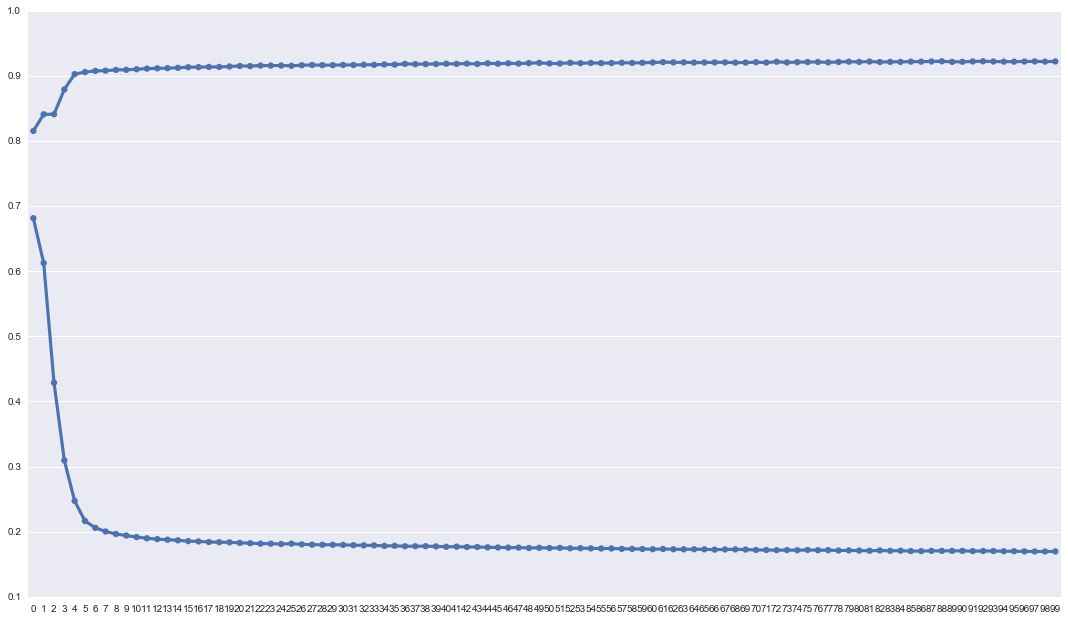

In [40]:
plot_history(history)

This is a tiny model, which really only does slightly worse than the baseline, interesting

In [41]:
def create_smaller():
    model = Sequential()
    model.add(Dense(output_dim = 32, input_dim = 65, init = 'normal', activation = 'relu'))
    model.add(Dense(output_dim = 1, init = 'normal', activation = 'sigmoid'))
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    return model

[[57682  2763]
 [ 3440  8083]]
             precision    recall  f1-score   support

          0       0.94      0.95      0.95     60445
          1       0.75      0.70      0.72     11523

avg / total       0.91      0.91      0.91     71968



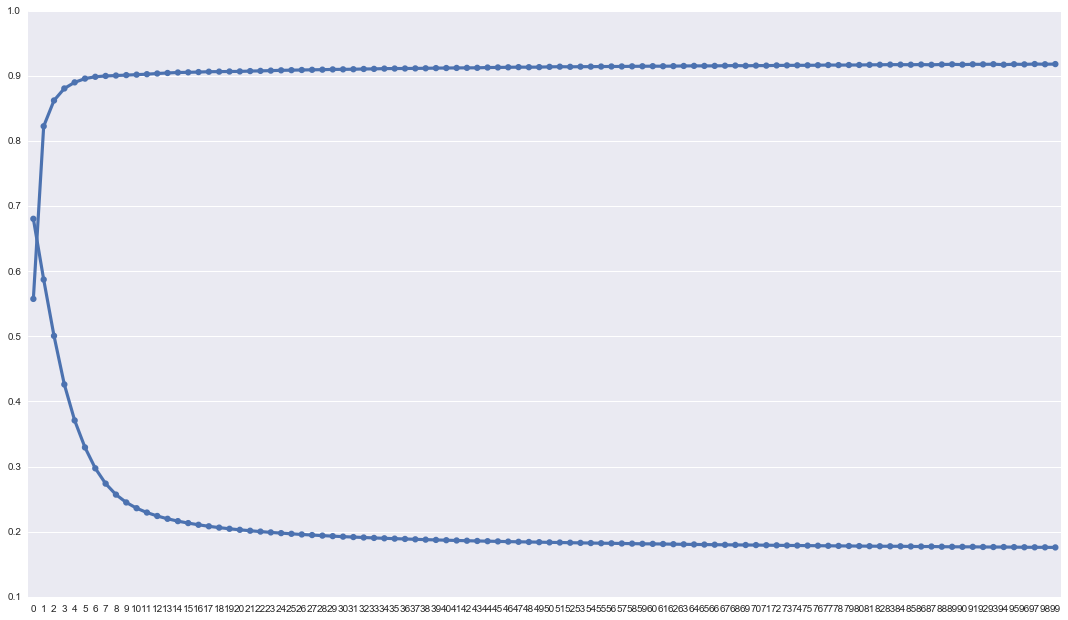

In [42]:
estimator = KerasClassifier(build_fn=create_smaller, nb_epoch=100, batch_size=10000, verbose=0)
history = estimator.fit(x_train_std, y_train)
y_test_pred = estimator.predict(x_test_std)
print confusion_matrix(y_test, y_test_pred)
print classification_report(y_test, y_test_pred)
plot_history(history)

halving the number of outputs really screws the precision for when people cancel. Also the recall is horrible, there are a lot of false negatives

In [43]:
def create_larger():
    model = Sequential()
    model.add(Dense(output_dim = 65, input_dim = 65, init = 'normal', activation = 'relu'))
    model.add(Dense(output_dim = 130, input_dim = 65, init = 'normal', activation = 'relu'))
    model.add(Dense(output_dim = 130, input_dim = 130, init = 'normal', activation = 'relu'))
    model.add(Dense(output_dim = 65, input_dim = 130, init = 'normal', activation = 'relu'))
    model.add(Dense(output_dim = 32, input_dim = 65, init = 'normal', activation = 'relu'))
    #model.add(Dense(output_dim = 32, input_dim = 65, init = 'normal', activation = 'relu'))
    model.add(Dense(output_dim = 1, init = 'normal', activation = 'sigmoid'))
    opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])
    return model

[[57192  3253]
 [ 2863  8660]]
[[ 0.94618248  0.05381752]
 [ 0.2484596   0.7515404 ]]
             precision    recall  f1-score   support

          0       0.95      0.95      0.95     60445
          1       0.73      0.75      0.74     11523

avg / total       0.92      0.92      0.92     71968



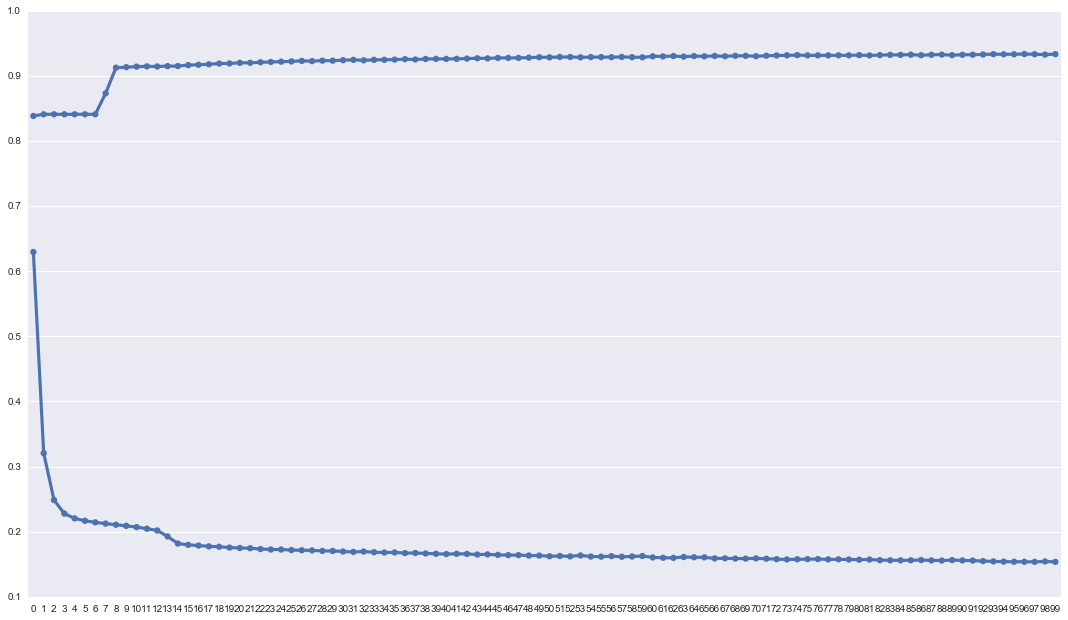

In [135]:
estimator = KerasClassifier(build_fn=create_larger, nb_epoch=100, batch_size=10000, verbose=0)
history = estimator.fit(x_train_std, y_train)
y_test_pred = estimator.predict(x_test_std)
print confusion_matrix(y_test, y_test_pred)
print performance(confusion_matrix(y_test, y_test_pred))
print classification_report(y_test, y_test_pred)
plot_history(history)

## Start Recurrent Net Code


Okay, so half the challenge with recurrent nets is that you need to feed them 'tensors' - 3d matrices with defined dimensions that correspond to (#samples, #time steps, #features). So all of the code below is just arranging the data so that it is in that format. If a site went 10 whole months without cancelling, it's coded as such. If a site went three months without cancelling, there are 7 rows of zeros added in, and then the three months of data preceding the cancel. This is to standardize the shape of the data, so the model will be happy with the input. 

In [91]:
data = pd.read_csv('data/all_customer_performance.csv')
data.fillna(0, inplace = True)

month_list = ['2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01', '2016-01-01', '2016-02-01', '2016-03-01',
             '2016-04-01', '2016-05-01', '2016-06-01']
grouped = data.groupby(by = ['site_id', 'month_year']).sum()
grouped.reset_index(level = 1, inplace = True)
#gets list of unique unique sites
unique_sites = grouped.index.unique()

grouped.reset_index(inplace = True)
grouped.drop('period', axis = 1, inplace = True)


In [92]:
# need to randomly sample from unique site ids, to choose sites to train and test on, can't just randomly 
# train_test_split that would mess up the month data.
# Also, the length of the training and test sites should preferably be both divisible by 100. This allows for the model
# to train faster on larger batch sizes. Set up an algebraic expression x * (54300) = however many training sets you want
training_sites = np.random.choice(unique_sites, int(round(0.7*len(unique_sites))), replace = False)
testing_sites = [site for site in unique_sites if site not in training_sites]

In [93]:
len(training_sites), len(testing_sites),len(training_sites) + len(testing_sites), len(unique_sites)

(38020, 16294, 54314, 54314)

In [94]:

rnn_train = grouped[grouped.site_id.isin(training_sites)]
rnn_test = grouped[grouped.site_id.isin(testing_sites)]

#scale the independent variables
sc = MinMaxScaler()
rnn_train.iloc[:,2:67] = sc.fit_transform(rnn_train.iloc[:,2:67])
rnn_test.iloc[:,2:67] = sc.transform(rnn_test.iloc[:,2:67])

rnn_train.shape, rnn_test.shape


((167722, 68), (72171, 68))

Iterates over unique sites for a dataset and returns a list of lists where each sub list is length of 10. Each sublist is a sequence of months for a particular site.

In [95]:
# iterates over unique sites for a dataset and returns a list of lists where each sub list is length of 10.
# Each sublist is a sequence of months for a particular site
def get_sequences(unique_sites, dataset, max_length = 10):
    grouped = dataset
    all_months = []
    for site in unique_sites:
        site_hist = grouped[grouped.site_id == site] #returns slice for that site
        sub = []
        for row in site_hist.values:
            cancelled = row[-1]
            if cancelled:
                sub.append(row[2:68])
                all_months.append(sub)
                sub = []
            else:
                sub.append(row[2:68])
        if len(sub) > 0:
            all_months.append(sub)
    for i in xrange(len(all_months)):
        all_months[i] = pad_sequences(np.asarray(all_months[i]).transpose(), maxlen = max_length, dtype = 'float64').transpose()
        
    return np.asarray(all_months)

In [96]:
# gets every tenth cancellation for model to train on. Flattens out dataset as side effect.
def create_dataset(dataset, cutoff = 10):
    dataX, dataY = [], []
    for i in xrange(dataset.shape[0]):
        site = dataset[i]
        for month in xrange(len(site)):
            x = site[month][0:65]
            dataX.append(x)
            if month == (cutoff - 1):
                y = site[month][65]
                dataY.append(y)
    return np.asarray(dataX), np.asarray(dataY)

In [97]:

look_back = 10
rnn_train = get_sequences(rnn_train.site_id.unique(), rnn_train, max_length = look_back)
rnn_test = get_sequences(rnn_test.site_id.unique(), rnn_test, max_length = look_back)
print rnn_train.shape, rnn_test.shape

#reshape data into x = t, y = t + 1
trainX, trainY = create_dataset(rnn_train, look_back)
testX, testY = create_dataset(rnn_test, look_back)

trainX_reshaped = np.reshape(trainX, (rnn_train.shape[0], rnn_train.shape[1], 65))
testX_reshaped = np.reshape(testX, (rnn_test.shape[0], rnn_test.shape[1], 65))
print trainX_reshaped.shape, testX_reshaped.shape

(42866, 10, 66) (18344, 10, 66)
(42866, 10, 65) (18344, 10, 65)


In [98]:
trainY.shape, testY.shape # one output per site

((42866,), (18344,))

In [99]:
take_off_train, take_off_test = rnn_train.shape[0] % 10, rnn_test.shape[0] % 10
take_off_train, take_off_test

(6, 4)

A helper function for plotting the loss and accuracy after each batch.

In [100]:
class LossHistory(keras.callbacks.Callback):
    """Tracks loss and accuracy per batch"""
    def on_train_begin(self, logs={}):
        self.losses = []
        self.acc = []

    def on_batch_end(self, batch, logs={}):
        
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))

In [101]:
# initializes weights with N(0,0.1)
def my_init(shape, name=None):
    return initializations.normal(shape, scale=0.01, name=name)

In [107]:
# Estimate model performance
if take_off_train != 0:
    trainScore = model.evaluate(trainX_reshaped[:-take_off_train], trainY[:-take_off_train], batch_size = batch_size, verbose=0)
    print('Train Score: ', trainScore)
else:
    trainScore = model.evaluate(trainX_reshaped[:], trainY[:], batch_size = batch_size, verbose=0)
    print('Train Score: ', trainScore)
if take_off_test != 0:
    testScore = model.evaluate(testX_reshaped[:-take_off_test], testY[:-take_off_test], batch_size= batch_size, verbose=0)
    print('Test Score: ', testScore)
else:
    testScore = model.evaluate(testX_reshaped[:], testY[:], batch_size= batch_size, verbose=0)
    print('Test Score: ', testScore)

('Train Score: ', [0.23003187387546317, 0.8965002299380731])
('Test Score: ', [0.22913254437929542, 0.89514721548560527])


In [108]:
if take_off_test != 0:
    predY = model.predict_classes(testX_reshaped[:-take_off_test], batch_size= batch_size, verbose = 0)
else:
    predY = model.predict_classes(testX_reshaped[:], batch_size= batch_size, verbose = 0)

In [109]:
if take_off_test != 0:
    count_test = 0
    for i in testY[:-take_off_test]:
        if i !=0:
            count_test += 1
    print 'actual count of cancelled: ', count_test
    count = 0
    for j in predY:
        if j !=0:
            count +=1 

    print 'predicted count of cancelled: ', count
    print 'difference: ', count_test - count
else:
    count_test = 0
    for i in testY[:]:
        if i !=0:
            count_test += 1
    print 'actual count of cancelled: ', count_test
    count = 0
    for j in predY:
        if j !=0:
            count +=1 

    print 'predicted count of cancelled: ', count
    print 'difference: ', count_test - count

actual count of cancelled:  11406
predicted count of cancelled:  12045
difference:  -639


In [110]:
if take_off_test != 0:
    print confusion_matrix(testY[:-take_off_test], np.ravel(predY))
    print performance(confusion_matrix(testY[:-take_off_test], np.ravel(predY)))
    print classification_report(testY[:-take_off_test], np.ravel(predY))
else:
    print confusion_matrix(testY[:], np.ravel(predY))
    print performance(confusion_matrix(testY[:], np.ravel(predY)))
    print classification_report(testY[:], np.ravel(predY))

[[ 5653  1281]
 [  642 10764]]
[[ 0.81525815  0.18474185]
 [ 0.05628617  0.94371383]]
             precision    recall  f1-score   support

        0.0       0.90      0.82      0.85      6934
        1.0       0.89      0.94      0.92     11406

avg / total       0.90      0.90      0.89     18340



The model correctly identifies a cancel 89% of the time. Of the times that the model predicted a cancel, 94% of them were actually a cancel. That's pretty damn good.

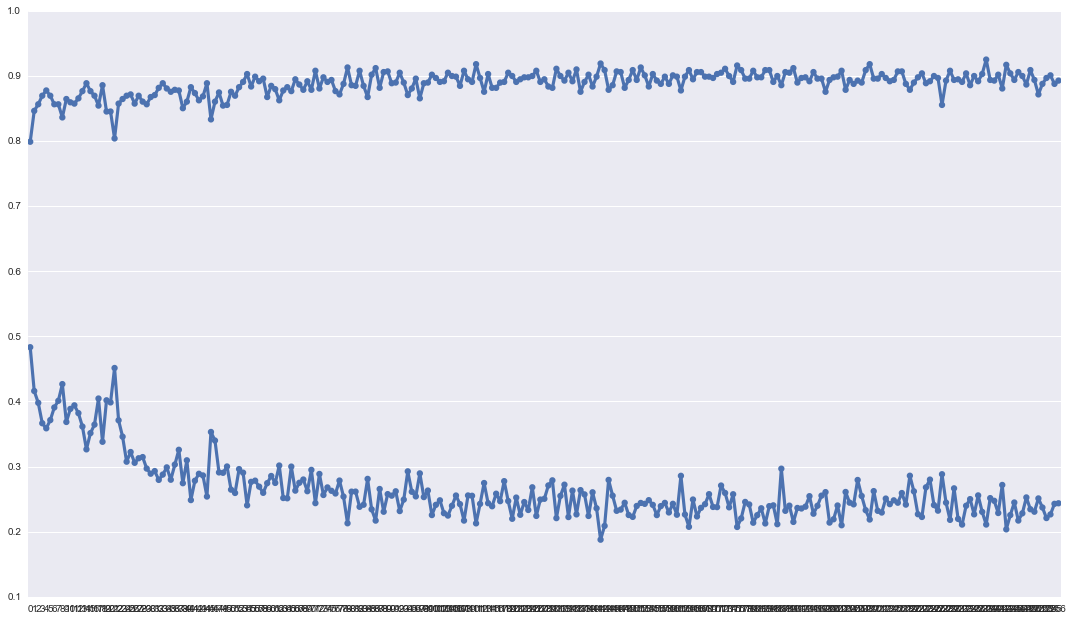

In [111]:
plot_history(history)

## this is supposed to actually be stateful

unfortunately, it takes forever to run and I no longer have access to the necessary data. The stateful model did marginally better than the previous model.

In [87]:
#true stateful model
batch_size = 1
look_back_state = 1
model = Sequential()
model.add(LSTM(65, init= my_init, activation='tanh', 
               batch_input_shape=(batch_size, look_back_state, 65),
               #input_shape = (look_back,65),
               return_sequences=True,
               stateful = True))
model.add(LSTM(130, init= my_init, activation='tanh', 
               batch_input_shape=(batch_size, look_back_state, 65),
               #input_shape = (look_back,65),
               return_sequences=True,
               stateful = True))
model.add(LSTM(130, init= my_init, activation='tanh', 
               batch_input_shape=(batch_size, look_back_state, 65),
               #input_shape = (look_back,65),
               return_sequences=True,
               stateful = True))
model.add(LSTM(65, init= my_init, activation='tanh', 
               batch_input_shape=(batch_size, look_back_state, 65),
               #input_shape = (look_back, 65),
               return_sequences=True,
               stateful = True))
model.add(LSTM(65, init= my_init, activation='tanh', 
               batch_input_shape=(batch_size, look_back_state, 65),
               #input_shape = (look_back, 65),
               return_sequences=True,
               stateful = True))
#model.add(TimeDistributed(Dense(32, init ='normal', activation = 'relu'), input_shape = (look_back_state, 65)))
model.add(LSTM(32, init= my_init, activation='tanh', 
               batch_input_shape=(batch_size, look_back_state, 65),
               #input_shape = (look_back,65),
               return_sequences=False,
               stateful = True))
model.add(Dense(1, init='normal', activation='sigmoid'))
opt = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08)
model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])

In [ ]:
print('Train...')
for epoch in range(2):
    mean_tr_acc = []
    mean_tr_loss = []
    for i in range(len(trainX_reshaped[:-take_off_train])):
        y_true = trainY[i]
        for j in range(look_back):
            tr_loss, tr_acc = model.train_on_batch(np.expand_dims(np.expand_dims(trainX_reshaped[i][j], axis=0), axis=1),
                                                   np.array([y_true]))
            mean_tr_acc.append(tr_acc)
            mean_tr_loss.append(tr_loss)
        model.reset_states()
        if i % 100 == 0:
            print 'sample number: ', i
            print('accuracy training = {}'.format(np.mean(mean_tr_acc)))
            print('loss training = {}'.format(np.mean(mean_tr_loss)))
            print('___________________________________')

    print('accuracy training = {}'.format(np.mean(mean_tr_acc)))
    print('loss training = {}'.format(np.mean(mean_tr_loss)))
    print('___________________________________')

    mean_te_acc = []
    mean_te_loss = []
    for i in range(len(testX_reshaped[:-take_off_test])):
        for j in range(look_back):
            te_loss, te_acc = model.test_on_batch(np.expand_dims(np.expand_dims(testX_reshaped[i][j], axis=0), axis=1),
                                                  testY[i])
            mean_te_acc.append(te_acc)
            mean_te_loss.append(te_loss)
        model.reset_states()

        for j in range(look_back):
            y_pred = model.predict_on_batch(np.expand_dims(np.expand_dims(testX_reshaped[i][j], axis=1), axis=1))
        model.reset_states()
        
        if i % 100 == 0:
            print('accuracy testing = {}'.format(np.mean(mean_te_acc)))
            print('loss testing = {}'.format(np.mean(mean_te_loss)))
            print('___________________________________')

    print('accuracy testing = {}'.format(np.mean(mean_te_acc)))
    print('loss testing = {}'.format(np.mean(mean_te_loss)))
    print('___________________________________')

## Conclusion

The trained rnn model does *significantly* better than the baseline model.The baseline model does okay only correctly identifies a cancel 69 percent of the time, and is only 75% precise. However, it is better at identifying no-cancel. On average, the rnn-model correctly identifies the sample 90% of the time. Of those predictions, they were a true positive 90% of the time.

Identifying a cancel is more important to us because that is lost revenue. Also, the majority of the time a customer does not cancel so the two classes are extremely unbalanced.

### Future work

Improve the architecture, initialize the weights such that a rectified linear unit activation can be used and the gradient does not explode. This is a tractable problem that more education will help.